# DNA_construct Introduction
DNA_construct is a flexible way to indicate a DNA sequence.

A DNA sequence is composed of a string of nucleotides. The sequence of these nucleotides can allow binding of other biomolecules such as proteins or RNA. We choose to annotate known binding interactions and other features of DNA sequences by considering them to be "DNA parts". a "part" has a certain function, and the order and orientation of parts on a dna sequence describes the overall function of that DNA sequence.

For example, a `Promoter` is a part which binds to RNA polymerase and causes everything downstream to be transcribed into RNA. A `Terminator`, then, is a sequence which stops the transcription of DNA into RNA. Therefore, anything between a `Promoter` and a `Terminator` gets turned into RNA.

Other parts such as a Ribosome Binding Site or `RBS`, binds to the ribosome, but only if it is made of RNA and not DNA. Thus, an `RBS` is _like_ a `Promoter`, but instead of RNA it makes Protein. As always the position and orientation of parts determines what those parts actually do. If your sequence contains a Coding Sequence (`CDS`) _before_ an `RBS`, then the ribosome actually cannot translate that protein. Likewise if your `RBS` is after a `Terminator`, that `RBS` never gets turned into RNA.

This type of logic is incorporated into `DNA_construct`.

The basic workflow is to first define a list of parts, then string them together into a `DNA_construct`

In [2]:
from biocrnpyler.core import Species
from biocrnpyler.components import RegulatedPromoter, Promoter, RBS, CDS, Terminator, DNA_construct
from biocrnpyler.mechanisms import Transcription_MM, Translation_MM, One_Step_Cooperative_Binding
from biocrnpyler.mixtures import TxTlExtract
from biocrnpyler.utils.plotting import render_network_bokeh 
try:
    #dnaplotlib is a cool library for plotting DNAs.
    #please use my fork located at https://github.com/dr3y/dnaplotlib
    #to install it type: pip install git+git://github.com/dr3y/dnaplotlib.git@master
    import dnaplotlib as dpl # type: ignore
    %matplotlib inline
    dpl_enabled = True
except (ModuleNotFoundError,ImportError) as e:
    dpl_enabled = False
print("imports done!")

def plotNetwork(inCRN,use_pretty_print=True,colordict = None,iterations=2000,rseed=30,posscale=1,export=False,colordict_append=None):
    try:
        from bokeh.models import (Plot , Range1d) # type: ignore

        import bokeh.plotting # type: ignore
        import bokeh.io # type: ignore
        bokeh.io.output_notebook() #this makes the graph appear in line with the notebook
        if(colordict is None):
            colordict={"complex":"cyan","protein":"green",
                        "GFP":"lightgreen",
                        "RFP":"red",
                        "ribosome":"blue",
                        "dna":"white","rna":"orange",
                        "ligand":"pink","phosphate":"yellow","nothing":"purple"}
        if(colordict_append is not None):
            colordict.update(colordict_append)
        #now you draw the network on the plot. Layout "force" is 
        plot = render_network_bokeh(inCRN,use_pretty_print=use_pretty_print,colordict=colordict,layout="force",iterations=iterations,rseed=rseed,posscale=posscale)
        bokeh.io.show(plot) #if you don't type this the plot won't show
        if(export):
            plot.output_backend = "svg"
            bokeh.io.export_svgs(plot, "plot_file.svg")
            
    except ModuleNotFoundError:
        return None




ptet = RegulatedPromoter("ptet",["tetr"],leak=True) #this is a repressible promoter
pconst = Promoter("pconst") #constitutive promoter
utr1 = RBS("UTR1") #regular RBS
gfp = CDS("GFP","GFP")
rfp = CDS("RFP","RFP")
t16 = Terminator("t16") #a terminator stops transcription


#now that the parts are defined, we can put together our construct.
parameters={"cooperativity":2,"kb":100, "ku":10, "ktx":.05, "ktl":.2, "kdeg":2,"kint":.05}

construct_1 = DNA_construct([[ptet,"forward"],[utr1,"forward"],[gfp,"forward"],[t16,"forward"]],\
                                mechanisms = {"transcription":Transcription_MM(Species("RNAP",material_type="protein")),\
                                    "translation":Translation_MM(Species("Ribosome",material_type="protein")),\
                                        "binding":One_Step_Cooperative_Binding()},parameters=parameters) 
''
#some very basic parameters are defined
parameters={"cooperativity":2,"kb":100, "ku":10, "ktx":.05, "ktl":.2, "kdeg":2,"kint":.05}

components = [construct_1]
myMixture = TxTlExtract(name = "txtl", parameters = parameters, components = components)
myCRN = myMixture.compile_crn()
print("enumerating components")
comps = myMixture.get_component(construct_1).enumerate_components()

w = construct_1.enumerate_components()
print()
print(w)

x = myCRN.species
print()
print("CRN species")
print('\n'.join([a.pretty_print() for a in x]))

y = myCRN.reactions
print()
print("CRN reactions")
print('\n'.join([a.pretty_print() for a in y]))
#'''


imports done!
enumerating components

[ptet_0, RNA_construct = UTR1_GFP_t16]

CRN species
dna[part[ptet-forward]:part[UTR1-forward]:part[GFP-forward]:part[t16-forward]]
protein[RNAP]
protein[Ribo]
protein[RNAase]
rna[part[UTR1-forward]:part[GFP-forward]:part[t16-forward]]
ordered_polymer[complex[part[ptet]:protein[RNAP]-forward]:part[UTR1-forward]:part[GFP-forward]:part[t16-forward]]
protein[tetr]
ordered_polymer[complex[part[ptet]:2x_protein[tetr]-forward]:part[UTR1-forward]:part[GFP-forward]:part[t16-forward]]
ordered_polymer[complex[complex[part[ptet]:2x_protein[tetr]]:protein[RNAP]-forward]:part[UTR1-forward]:part[GFP-forward]:part[t16-forward]]
protein[Ribosome]
ordered_polymer[complex[part[UTR1]:protein[Ribosome]-forward]:part[GFP-forward]:part[t16-forward]]
protein[GFP]
complex[protein[RNAase]:rna[part[UTR1-forward]:part[GFP-forward]:part[t16-forward]]]

CRN reactions
dna[part[ptet-forward]:part[UTR1-forward]:part[GFP-forward]:part[t16-forward]]+protein[RNAP] <--> ordered_polyme

In [3]:
from biocrnpyler.components import CombinatorialPromoter
from biocrnpyler.utils.plotting import render_constructs
try:
    #dnaplotlib is a cool library for plotting DNAs.
    #please use my fork located at https://github.com/dr3y/dnaplotlib
    #to install it type: pip install git+git://github.com/dr3y/dnaplotlib.git@master
    import dnaplotlib as dpl # type: ignore
    dpl_enabled = True
except (ModuleNotFoundError,ImportError) as e:
    dpl_enabled = False

print("imports done!")

#part definitions below

ptet = RegulatedPromoter("ptet",["tetr"],leak=True) #this is a repressible promoter
pconst = Promoter("pconst") #constitutive promoter
pcomb = CombinatorialPromoter("pcomb",["arac","laci"], leak=False,
                              tx_capable_list = [["arac"], ["laci"]]) #the Combinations A and B or just A or just B be transcribed
utr1 = RBS("UTR1") #regular RBS
utr2 = RBS("UTR1") #regular RBS
gfp = CDS("GFP") #a CDS has a name and a protein name. so this one is called GFP and the protein is also called GFP
fusrfp = CDS("fusRFP","RFP",no_stop_codons=["forward"]) #you can say that a protein has no stop codon. This is a little different from a fusion protein, because in this case you are saying that the ribosome reads through two proteins but still produces two distinct proteins, rather than one fused protein. This can happen in the case of the ta peptide which causes a peptide bond not to be formed while making a protein.
rfp = CDS("RFP") #regular RFP
cfp = CDS("CFP") #cfp
t16 = Terminator("t16") #a terminator stops transcription


#now that the parts are defined, we can put together our construct.
construct_1 = DNA_construct([[ptet,"forward"],[utr1,"forward"],[gfp,"forward"],[t16,"forward"]])
construct_2 = DNA_construct([[t16,"reverse"],[rfp,"reverse"],[utr1,"reverse"],[pconst,"reverse"]])

#now, we are using dnaplotlib to plot the constructs


if(dpl_enabled):
    cdict = {"GFP":"green","RFP":"red","pconst":"black","Terminator":"black"}
    render_constructs([construct_1,construct_2],color_dictionary=cdict)
#some very basic parameters are defined
parameters={"cooperativity":2,"kb":100, "ku":10, "ktx":.05, "ktl":.2, "kdeg":2,"kint":.05}

components = [construct_1,construct_2]
myMixture = TxTlExtract(name = "txtl", parameters = parameters, components = components)

print("enumerating components")
#comps = myMixture.get_component(construct_1).enumerate_components()

myCRN = myMixture.compile_crn()

x = myCRN.species
print()
print("CRN species")
print('\n'.join([a.pretty_print() for a in x]))

y = myCRN.reactions
print()
print("CRN reactions")
print('\n'.join([str(a) for a in y]))

imports done!
enumerating components

CRN species
dna[part[ptet-forward]:part[UTR1-forward]:part[GFP-forward]:part[t16-forward]]
dna[part[t16-reverse]:part[RFP-reverse]:part[UTR1-reverse]:part[pconst-reverse]]
protein[RNAP]
protein[Ribo]
protein[RNAase]
rna[part[UTR1-forward]:part[GFP-forward]:part[t16-forward]]
ordered_polymer[complex[part[ptet]:protein[RNAP]-forward]:part[UTR1-forward]:part[GFP-forward]:part[t16-forward]]
protein[tetr]
ordered_polymer[complex[part[ptet]:2x_protein[tetr]-forward]:part[UTR1-forward]:part[GFP-forward]:part[t16-forward]]
ordered_polymer[complex[complex[part[ptet]:2x_protein[tetr]]:protein[RNAP]-forward]:part[UTR1-forward]:part[GFP-forward]:part[t16-forward]]
rna[part[UTR1-forward]:part[RFP-forward]:part[t16-forward]]
ordered_polymer[part[t16-reverse]:part[RFP-reverse]:part[UTR1-reverse]:complex[part[pconst]:protein[RNAP]-reverse]]
ordered_polymer[complex[part[UTR1]:protein[Ribo]-forward]:part[GFP-forward]:part[t16-forward]]
protein[GFP]
ordered_polymer[c

You can see that for the first construct, your DNA is given an automatic name: `ptet_f_UTR1_f_GFP_f_t16_f`. 

The RNA made from your DNA is also given an automatic name: `UTR1_f_GFP_f_t16_f`

Likewise for the second construct, which I've made in reverse to make the difference more apparent. Though you'll see that the RNA from the second construct is still produced in the right orientation, so the RNA is shown in the forwards direction.

This is because DNA and RNA are now represented as an OrderedPolymer. Each member of the OrderedPolymer represents a part. So, in the case of promoters or RBSes, you'll see ribosomes and polymerases bind directly to the part inside the OrderedPolymer.

Loading BokehJS ...

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\utils\plotting.py:166: UserWarning: Node keys in 'layout_function' don't match node keys in the graph. These nodes may not be displayed correctly.
  reaction_renderer = from_networkx(DGreactions, positions, center=(0, 0))
C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\utils\plotting.py:167: UserWarning: Node keys in 'layout_function' don't match node keys in the graph. These nodes may not be displayed correctly.
  species_renderer = from_networkx(DGspecies, positions, center=(0, 0))


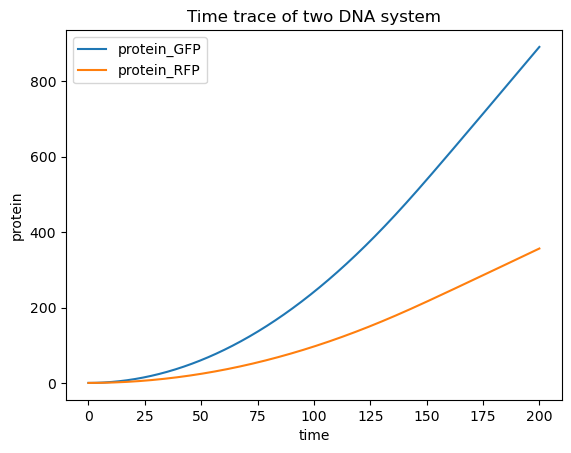

In [5]:
#here we are plotting the network diagram and simulating the system with some basic parameters

plotNetwork(myCRN,colordict_append={"GFP":"green","RFP":"red"})
try:
    import numpy as np
    import matplotlib.pyplot as plt
    timepoints = np.linspace(0, 200, 1000)
    x0 = {construct_1.get_species():5.0,
        construct_2.get_species():2.0, "protein_RNAP":10., "protein_Ribo":50.}
    Re1 = myCRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0)
    if(Re1 is not None):
        plt.plot(timepoints,Re1["protein_GFP"], label = "protein_GFP")
        plt.plot(timepoints,Re1["protein_RFP"], label = "protein_RFP")
        plt.title("Time trace of two DNA system")
        plt.xlabel("time")
        plt.ylabel("protein")
        plt.legend()
        plt.show()
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')




That seems pretty straightforward but now let's see what happens if we put both on the same piece of DNA:

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\chemical_reaction_network.py:362: UserWarning: Trying to set species that is not in model: protein_arac
  m.set_species(processed)


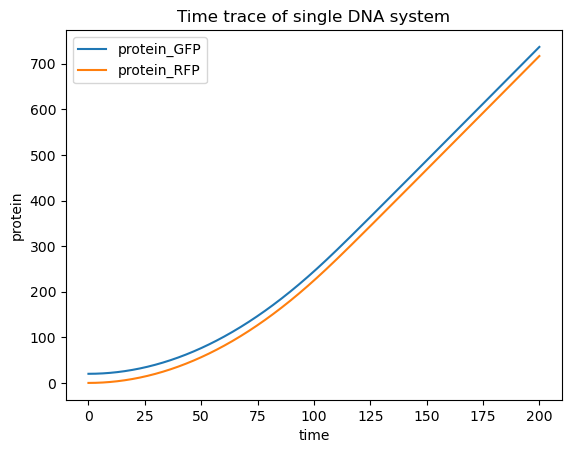

In [6]:
construct_3 = DNA_construct([[ptet,"forward"],[utr1,"forward"],[gfp,"forward"],[t16,"forward"],[t16,"reverse"],[rfp,"reverse"],[utr1,"reverse"],[pconst,"reverse"]])
#now, we are using dnaplotlib to plot the constructs

if(dpl_enabled):
    render_constructs([construct_3])

#some very basic parameters are defined
parameters={"cooperativity":2,"kb":100, "ku":10, "ktx":.05, "ktl":.2, "kdeg":2,"kint":.05}

components = [construct_3]
myMixture = TxTlExtract(name = "txtl", parameters = parameters, components = components)
myCRN = myMixture.compile_crn()
''
try:
    import numpy as np
    import matplotlib.pyplot as plt
    timepoints = np.linspace(0, 200, 1000)
    x0 = {construct_3.get_species():5.0, "protein_GFP":20,"protein_RNAP":10., "protein_Ribo":50.,"protein_arac":20}
    #I started the GFP at a slightly elevated value so you can see the two lines on top of each other in the graph
    Re1 = myCRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0)
    if(Re1 is not None):
        plt.figure()
        plt.plot(timepoints,Re1["protein_GFP"], label = "protein_GFP")
        plt.plot(timepoints,Re1["protein_RFP"], label = "protein_RFP")
        #plt.plot(timepoints,Re1["rna_mydna"], label = "rna_mydna")
        #plt.gca().set_yscale("log")
        plt.title("Time trace of single DNA system")
        plt.xlabel("time")
        plt.ylabel("protein")
        plt.legend()
        
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
#'''

The same RNAs and proteins are made, but the network diagram should be a bit more complicated, owing to the combinatorial binding to the DNA molecule

In [7]:
plotNetwork(myCRN)


Loading BokehJS ...

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\utils\plotting.py:166: UserWarning: Node keys in 'layout_function' don't match node keys in the graph. These nodes may not be displayed correctly.
  reaction_renderer = from_networkx(DGreactions, positions, center=(0, 0))
C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\utils\plotting.py:167: UserWarning: Node keys in 'layout_function' don't match node keys in the graph. These nodes may not be displayed correctly.
  species_renderer = from_networkx(DGspecies, positions, center=(0, 0))


Now you can see that many more arrows lead to each RNA. But there is still only one promoter per RNA, how can it be? Well, now that both promoters and transcripts are on the same DNA, we must take into account the fact that you can have both promoters with RNA polymerase bound, so for example Promoter1 can lead to RNA1 whether or not Promoter2 is bound by RNAP.

We can even make a more complicated DNA construct, such as what happens before and after a promoter is "flipped" by integrase activity

In [8]:
from biocrnpyler.components import IntegraseSite, IntegraseRule, Integrase_Enumerator
attB = IntegraseSite("attB","attB",integrase="Bxb1")
attP = IntegraseSite("attP","attP",integrase="Bxb1")

diffatt = IntegraseSite("attL","attL",integrase="phic31")

construct_1 = DNA_construct([[t16,"reverse"],[rfp,"reverse"],[utr1,"reverse"],[attP,"forward"],[pconst,"forward"],[attB,"reverse"],[utr1,"forward"],[gfp,"forward"],[t16,"forward"]])

components = [construct_1]
bxb1 = Integrase_Enumerator("Bxb1", int_mechanisms={"Bxb1":IntegraseRule("Bxb1")})

myMixture = TxTlExtract(name = "txtl", parameters = parameters, components = components,global_component_enumerators=[bxb1])


#now, we are using dnaplotlib to plot the constructs
enumerated_constructs = myMixture.global_component_enumeration(recursion_depth=4)
myCRN = myMixture.compile_crn()
if(dpl_enabled):
    conlist = []
    for con in enumerated_constructs:
        if(isinstance(con,DNA_construct)):
            conlist += [con]
    render_constructs(conlist)
#some very basic parameters are defined
parameters={"cooperativity":2,"kb":100, "ku":10, "ktx":.05, "ktl":.2, "kdeg":2,"kint":.05}


print("done")

done


And we can see that this construct 'knows' that a forward facing promoter will not produce RNAs that face the reverse direction.

In [9]:


plotNetwork(myCRN,colordict={"complex":"cyan","protein":"green",
                        "GFP":"lightgreen",
                        "RFP":"red",
                        "ribosome":"blue",
                        "dna":"white","rna":"orange",
                        "ligand":"pink","phosphate":"yellow","nothing":"purple", "Bxb1":"yellow"})

Loading BokehJS ...

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\utils\plotting.py:166: UserWarning: Node keys in 'layout_function' don't match node keys in the graph. These nodes may not be displayed correctly.
  reaction_renderer = from_networkx(DGreactions, positions, center=(0, 0))
C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\utils\plotting.py:167: UserWarning: Node keys in 'layout_function' don't match node keys in the graph. These nodes may not be displayed correctly.
  species_renderer = from_networkx(DGspecies, positions, center=(0, 0))


# Overview for developers
Several key additions had to be made to biocrnpyler to make this possible. 

1. `Complex()` is a new function that you should use every time you want to make a ComplexSpecies. It should do exactly the same thing as the ComplexSpecies constructor, unless one of the species that you gave it is an OrderedComplexSpecies that has a 'bindloc' attribute, then instead of making a ComplexSpecies the function will make an OrderedComplexSpecies that is correctly formed.

2. `OrderedPolymer` `OrderedMonomer` and `OrderedPolymerSpecies` are new data members that represent sequences of parts. A piece of DNA with many binding sites is represented as an OrderedPolymerSpecies. Because mechanisms and Components are agnostic of binding location; that is to say, they usually have code that looks like this: `make_complex([dna,protein])`, we must give them some way of knowing _where_ on that `dna` the `protein` should end up. To do this, you must pass an `OrderedMonomer` into a `Component` which belongs to an `OrderedPolymer`. Through the use of the `Complex()` function, the proper complex will be made, to the correct member of the `OrderedPolymer` which the `OrderedMonomer` belongs to.

3. `DNA_part` inherits from `Component`, and every dna part such as `Promoter` now inherits from `DNA_part` instead of `Component`. This allows the storage of things like position, direction, and parent construct inside anything that used to be a `Component`

4. `CDS` is a `DNA_part` which gives rise to a `Species`. It felt weird to put `Protein` objects into a DNA sequence so I created this. It only makes the protein if it is read in the 'forward' direction.

4. `DNA_construct` contains a list of `DNA_part`s together with their directions. `DNA_construct` also has `update_species()` and `update_reactions()` so that it can generate the necessary species and reactions if it will be part of a CRN. Likewise, `RNA_construct` does the same thing for RNA. A `DNA_construct` can give rise to many `RNA_construct`s when it compiles. This is done through the action of `explore_txtl()`

5. `explore_txtl()` is a function of `DNA_construct` which figures out the RNA and Proteins that a DNA produces. It works basically by going along a DNA part by part, remembering which parts came before, and taking into account the directions of parts. In general it will traverse a `DNA_construct` in the "forward" and "reverse" directions. It is hard coded to know that `RBS` parts make proteins and `Promoter` parts make RNAs, but only when their orientation is "forward" relative to the direction it's currently looking at. Other things are taken account too, for example, an `RBS` can only make a `Protein` if it is part of an RNA. Most of this logic is encapsulated in an object called `TxTl_explorer`.

6. `update_components()` is a function of `DNA_construct` which creates many copies of the `DNA_part`s which make up the `DNA_construct`. This is necessary for making all combinatorial complexes. First, every `DNA_part` is fed in an `OrderedComplexSpecies` corresponding to the unbound DNA, which has the appropriate "bindloc_". Then, the `Species` produced by `update_species()` each have complexes in only one location. All possible combinations of bound species are then generated from this set of `OrderedComplexSpecies`. Then, these combinatorial complexes are fed _back_ into the `DNA_part`s, generating a new `DNA_part` that is responsible for generating species and reactions that include that combinatorial complex. For example, if you have  `DNA_construct` containing a `Promoter` and an `AttachmentSite`, then `update_components()` should generate two `Promoter` parts, one that has the unbound `OrderedComplexSpecies` and one that has an `OrderedComplexSpecies` that has integrases bound to it. Then, these new `Component`s can be used to make species and reactions using their respective `update_species()` and `update_reactions()`
